In [ ]:
# make connection to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install tensorflow library
!pip install tensorflow

In [ ]:
# import relevant image, data analysis and deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# import relevant libraries for classification metrics and quantitative analysis
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
# disable GPU memory growth to prevent OOM errors
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except:
        print("Invalid device or cannot modify virtual devices once initialized.")

In [ ]:
# configuration parameters
IMAGE_SIZE = 224 # size vision transformers expect
PATCH_SIZE = 16 # size of patches to extract from input image
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2 # total number of patches in the image
PROJECTION_DIM = 256 # embedding dimension for patches
NUM_HEADS = 4 # number of attention heads
TRANSFORMER_LAYERS = 4 # number of transformer layers
MLP_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM] # hidden units in mlp block
DROPOUT_RATE = 0.1 # dropout rate
BATCH_SIZE = 32 # number of samples per batch
EPOCHS = 30 # number of training epochs
NUM_CLASSES = 2 # binary classification: normal vs leukemia

In [ ]:
# define function to load images and resize them
def load_data(data_dir, img_size=IMAGE_SIZE):
  dataset = tf.keras.preprocessing.image_dataset_from_directory( # load images from directory
      data_dir, # path to dataset folder
      image_size=(img_size, img_size), # resize images to target size
      batch_size=BATCH_SIZE, # number of images per batch
      color_mode='rgb', # load images in rgb format
      label_mode='categorical' # one-hot encode the labels
  )

  # normalize data
  normalization_layer = layers.Rescaling(1./255) # create rescaling layer to normalize pixel values
  dataset = dataset.map(lambda x, y: (normalization_layer(x), y)) # apply normalization to all batches

  return dataset # return preprocessed dataset

In [ ]:
# define a function to build a multi-layer perceptron block
def mlp(x, dropout_rate, hidden_units):
  for units in hidden_units: # iterate through list of hidden unit sizes
      x = layers.Dense(units, activation=tf.nn.gelu)(x) # apply dense layer with gelu activation
      x = layers.Dropout(dropout_rate)(x) # apply dropout for regularization
  return x # return the output tensor after mlp layers

In [ ]:
# custom keras layer to encode patches with position information
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim): # initialize with number of patches and projection dimension
      super(PatchEncoder, self).__init__() # initialize base layer class
      self.num_patches = num_patches # store number of patches
      self.projection = layers.Dense(units=projection_dim) # dense layer to project patches into embedding space
      self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim) # learnable position embeddings

  def call(self, patch): # forward pass
      positions = tf.range(start=0, limit=self.num_patches, delta=1) # generate positions for each patch
      encoded = self.projection(patch) + self.position_embedding(positions) # add position embedding to patch projection
      return encoded # return encoded patch representation

In [ ]:
# define function to create vision transformer model
def create_vit_model(input_shape, patch_size, num_patches, projection_dim, num_transformer_layers, num_heads, mlp_units, dropout_rate=0.1, num_classes=2):
  inputs = layers.Input(shape=input_shape) # input layer with specified shape

  # create patches
  patches = layers.Conv2D( # apply conv2d to slice image into patches
      filters=projection_dim, # number of output channels equals embedding dimension
      kernel_size=(patch_size, patch_size), # kernel size equal to patch size
      strides=(patch_size, patch_size), # move kernel by patch size (non-overlapping)
      padding="VALID", # no padding
  )(inputs)
  patch_dims = patches.shape[1] * patches.shape[2] # flatten spatial dimensions
  patches = layers.Reshape((patch_dims, projection_dim))(patches) # reshape into (num_patches, projection_dim)

  # encode patches with positional information
  encoder = PatchEncoder(num_patches, projection_dim) # create patch encoder
  encoded_patches = encoder(patches) # apply encoder to patches

  # add [cls] token
  cls_token = layers.Lambda(lambda x: tf.zeros((tf.shape(x)[0], 1, projection_dim)))(encoded_patches) # create cls token as zeros
  encoded_patches = layers.Concatenate(axis=1)([cls_token, encoded_patches]) # prepend cls token to patch sequence

  # create transformer blocks
  for _ in range(num_transformer_layers): # repeat for number of transformer layers
      x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches) # apply first layer normalization
      attention_output = layers.MultiHeadAttention( # apply multi-head self-attention
          num_heads=num_heads, key_dim=projection_dim // num_heads
      )(x1, x1)
      x2 = layers.Add()([attention_output, encoded_patches]) # skip connection after attention
      x3 = layers.LayerNormalization(epsilon=1e-6)(x2) # second layer normalization
      x3 = mlp(x3, dropout_rate, mlp_units) # pass through mlp block
      encoded_patches = layers.Add()([x3, x2]) # skip connection after mlp

  # final layer normalization
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

  # use only the cls token representation
  representation = representation[:, 0]

  # classification head
  features = layers.Dense(projection_dim, activation="relu")(representation) # dense layer with relu activation
  features = layers.Dropout(dropout_rate)(features) # apply dropout
  logits = layers.Dense(num_classes)(features) # final dense layer without activation
  outputs = layers.Activation("softmax")(logits) # apply softmax to get class probabilities

  model = keras.Model(inputs=inputs, outputs=outputs) # create keras model
  return model # return model object

In [ ]:
# define function to build and compile the vision transformer model
def build_and_compile_vit_model():
  input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3) # define input shape with image size and 3 color channels
  vit_model = create_vit_model( # create the vit model with given parameters
      input_shape=input_shape,
      patch_size=PATCH_SIZE,
      num_patches=NUM_PATCHES,
      projection_dim=PROJECTION_DIM,
      num_transformer_layers=TRANSFORMER_LAYERS,
      num_heads=NUM_HEADS,
      mlp_units=MLP_UNITS,
      dropout_rate=DROPOUT_RATE,
      num_classes=NUM_CLASSES
  )

  vit_model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-4), # use adam optimizer with specified learning rate
      loss=keras.losses.CategoricalCrossentropy(), # use categorical crossentropy loss for multi-class classification
      metrics=[ # define metrics to monitor during training
          keras.metrics.CategoricalAccuracy(name="accuracy"), # accuracy metric
          keras.metrics.AUC(name="auc"), # area under the roc curve
          keras.metrics.Precision(name="precision"), # precision metric
          keras.metrics.Recall(name="recall") # recall metric
      ]
  )
  return vit_model # return compiled model

In [ ]:
# define function to apply data augmentation to training dataset
def augment_data(train_dataset):
  data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal"), # randomly flip images horizontally
      layers.RandomRotation(0.1), # apply random rotation up to 10%
      layers.RandomZoom(0.1), # apply random zoom to images
      layers.RandomContrast(0.1), # adjust contrast randomly within a small range
  ])

  train_dataset = train_dataset.map( # apply data augmentation to each image in dataset
      lambda x, y: (data_augmentation(x, training=True), y), # augment input images, keep labels unchanged
      num_parallel_calls=tf.data.AUTOTUNE # use autotune for parallel data processing
  )

  return train_dataset # return augmented dataset

In [ ]:
# define function to create list of training callbacks
def get_callbacks():
  # save model with best validation auc
  checkpoint = ModelCheckpoint(
      "vit_leukemia_model.h5", # filepath to save best model
      monitor="val_auc", # monitor validation auc metric
      verbose=1, # log when model is saved
      save_best_only=True, # save only if model improves
      mode="max" # looking to maximize auc
  )

  # stop training early if performance doesn't improve
  early_stopping = EarlyStopping(
      monitor="val_auc", # monitor validation auc
      patience=5, # wait 5 epochs before stopping
      restore_best_weights=True, # restore model with best performance
      mode="max" # looking to maximize auc
  )

  # reduce learning rate when val loss plateaus
  reduce_lr = ReduceLROnPlateau(
      monitor="val_loss", # monitor validation loss
      factor=0.2, # reduce learning rate by a factor of 0.2
      patience=3, # wait 3 epochs without improvement
      min_lr=1e-6, # minimum learning rate
      mode="min" # looking to minimize loss
  )

  return [checkpoint, early_stopping, reduce_lr] # return list of callbacks

In [ ]:
# define function to plot accuracy and loss for multiple folds
def plot_history(histories):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))
  ax1, ax2 = axes

  # iterate through history objects with index
  for i, h in enumerate(histories):
    ax1.plot(h.history['accuracy'], label=f'Fold {i} Train') # plot training accuracy
    ax1.plot(h.history['val_accuracy'], label=f'Fold {i} Val') # plot validation accuracy
    ax2.plot(h.history['loss'], label=f'Fold {i} Train') # plot training loss
    ax2.plot(h.history['val_loss'], label=f'Fold {i} Val') # plot validation loss

  ax1.set_title('Model Accuracy')
  ax1.set_ylabel('Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.legend(loc='lower right')

  ax2.set_title('Model Loss')
  ax2.set_ylabel('Loss')
  ax2.set_xlabel('Epoch')
  ax2.legend(loc='upper right')

  plt.tight_layout()
  plt.savefig('balanced-vit_training_history_all_folds.png')
  plt.show()

In [ ]:
# define function to evaluate model on test data
def evaluate_model(model, test_dataset):
    y_true = [] # list to store true labels
    y_pred = [] # list to store predicted labels

    # iterate through test dataset batches
    for x, y in test_dataset:
        predictions = model.predict(x) # get model predictions for batch
        y_true.extend(np.argmax(y.numpy(), axis=1)) # convert one-hot labels to class indices and add to y_true
        y_pred.extend(np.argmax(predictions, axis=1)) # get predicted class indices and add to y_pred

    # print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Leukemia"]))

    # print confusion matrix
    cm = confusion_matrix(y_true, y_pred) # compute confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Normal", "Leukemia"])
    plt.yticks(tick_marks, ["Normal", "Leukemia"])

    # add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]): # iterate over matrix rows
        for j in range(cm.shape[1]): # iterate over matrix columns
            plt.text(j, i, format(cm[i, j], 'd'), # display value at each cell
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('balanced-vit_confusion_matrix.png')
    plt.show()

In [ ]:
# set data paths
TRAIN_DATA_DIR = "/content/drive/My Drive/C-NMC/training_data/"
VAL_DATA_DIR = "/content/drive/My Drive/C-NMC/validation_data/"
TEST_DATA_DIR = "/content/drive/My Drive/C-NMC/testing_data/C-NMC_test_final_phase_data"

In [ ]:
# load validation dataset
val_dataset = load_data(VAL_DATA_DIR)

Found 1877 files belonging to 2 classes.


In [ ]:
# configure validation dataset for performance
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
# build and compile model
print("Building Vision Transformer model...")
vit_model = build_and_compile_vit_model()

Building Vision Transformer model...


In [ ]:
# show model summary
vit_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │    196,864 │ input_layer[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 196, 256)  │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 196, 256)  │    115,968 │ reshape[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 256)    │          0 │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 197, 256)  │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 197, 256)  │        512 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 197, 256)  │    263,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 197, 256)  │          0 │ multi_head_atten… │
│                     │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 197, 256)  │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 197, 512)  │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 197, 512)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 197, 256)  │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 197, 256)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 197, 256)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 197, 256)  │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 197, 256)  │    263,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 197, 256)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 197, 256)  │        512 │ add_2[0][0]     

 Total params: 2,488,066 (9.49 MB)

 Trainable params: 2,488,066 (9.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train model
callbacks = get_callbacks() # retrieve training callbacks
folds = ['fold_0', 'fold_1', 'fold_2'] # list of dataset folds for cross-validation
history = [] # list to store training history for each fold

# iterate through each fold
for fold in folds:
  print(f"{fold}\n") # print current fold name
  FOLD_TRAIN_DATA_DIR = os.path.join(TRAIN_DATA_DIR,fold) # construct path to training data for current fold
  train_dataset = load_data(FOLD_TRAIN_DATA_DIR) # load and preprocess dataset
  train_dataset = augment_data(train_dataset) # apply data augmentation
  train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE) # prefetch batches for efficient loading
  history.append(vit_model.fit( # train the model and store history
      train_dataset,
      epochs=EPOCHS, # number of training epochs
      validation_data=val_dataset,
      callbacks=callbacks # use early stopping, checkpointing, lr reduction
  ))

fold_0

Found 4794 files belonging to 2 classes.
Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6124 - auc: 0.6434 - loss: 0.6963 - precision: 0.6124 - recall: 0.6124
Epoch 1: val_auc improved from -inf to 0.59380, saving model to vit_leukemia_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 516s 3s/step - accuracy: 0.6125 - auc: 0.6435 - loss: 0.6961 - precision: 0.6125 - recall: 0.6125 - val_accuracy: 0.5791 - val_auc: 0.5938 - val_loss: 0.7222 - val_precision: 0.5791 - val_recall: 0.5791 - learning_rate: 1.0000e-04
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6723 - auc: 0.7286 - loss: 0.6157 - precision: 0.6723 - recall: 0.6723
Epoch 2: val_auc improved from 0.59380 to 0.69060, saving model to vit_leukemia_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.6723 - auc: 0.7286 - loss: 0.6156 - precision: 0.6723 - recall: 0.6723 - val_accuracy: 0.6638 - val_auc: 0.6906 - val_loss: 0.6298 - val_precision: 0.6638 - val_recall: 0.6638 - learning_rate: 1.0000e-04
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6784 - auc: 0.7450 - loss: 0.5964 - precision: 0.6784 - recall: 0.6784
Epoch 3: val_auc improved from 0.69060 to 0.70112, saving model to vit_leukemia_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.6784 - auc: 0.7451 - loss: 0.5964 - precision: 0.6784 - recall: 0.6784 - val_accuracy: 0.6995 - val_auc: 0.7011 - val_loss: 0.6248 - val_precision: 0.6995 - val_recall: 0.6995 - learning_rate: 1.0000e-04
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6908 - auc: 0.7472 - loss: 0.5954 - precision: 0.6908 - recall: 0.6908
Epoch 4: val_auc did not improve from 0.70112
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.6908 - auc: 0.7472 - loss: 0.5954 - precision: 0.6908 - recall: 0.6908 - val_accuracy: 0.6393 - val_auc: 0.6694 - val_loss: 0.6549 - val_precision: 0.6393 - val_recall: 0.6393 - learning_rate: 1.0000e-04
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6998 - auc: 0.7648 - loss: 0.5799 - precision: 0.6998 - recall: 0.6998
Epoch 5: val_auc improved from 0.70112 to 0.70222, saving model to vit_leukemia_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.6998 - auc: 0.7648 - loss: 0.5799 - precision: 0.6998 - recall: 0.6998 - val_accuracy: 0.6676 - val_auc: 0.7022 - val_loss: 0.6311 - val_precision: 0.6676 - val_recall: 0.6676 - learning_rate: 1.0000e-04
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6974 - auc: 0.7555 - loss: 0.5874 - precision: 0.6974 - recall: 0.6974
Epoch 6: val_auc did not improve from 0.70222
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.6975 - auc: 0.7555 - loss: 0.5873 - precision: 0.6975 - recall: 0.6975 - val_accuracy: 0.5818 - val_auc: 0.6032 - val_loss: 0.7003 - val_precision: 0.5818 - val_recall: 0.5818 - learning_rate: 1.0000e-04
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7042 - auc: 0.7748 - loss: 0.5703 - precision: 0.7042 - recall: 0.7042
Epoch 7: val_auc improved from 0.70222 to 0.73076, saving model to vit_leukemia_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.7043 - auc: 0.7748 - loss: 0.5703 - precision: 0.7043 - recall: 0.7043 - val_accuracy: 0.6921 - val_auc: 0.7308 - val_loss: 0.6120 - val_precision: 0.6921 - val_recall: 0.6921 - learning_rate: 2.0000e-05
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7217 - auc: 0.7905 - loss: 0.5535 - precision: 0.7217 - recall: 0.7217
Epoch 8: val_auc improved from 0.73076 to 0.73457, saving model to vit_leukemia_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.7217 - auc: 0.7905 - loss: 0.5535 - precision: 0.7217 - recall: 0.7217 - val_accuracy: 0.6798 - val_auc: 0.7346 - val_loss: 0.6070 - val_precision: 0.6798 - val_recall: 0.6798 - learning_rate: 2.0000e-05
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7203 - auc: 0.7813 - loss: 0.5645 - precision: 0.7203 - recall: 0.7203
Epoch 9: val_auc improved from 0.73457 to 0.74807, saving model to vit_leukemia_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.7203 - auc: 0.7813 - loss: 0.5645 - precision: 0.7203 - recall: 0.7203 - val_accuracy: 0.6841 - val_auc: 0.7481 - val_loss: 0.5966 - val_precision: 0.6841 - val_recall: 0.6841 - learning_rate: 2.0000e-05
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7320 - auc: 0.8012 - loss: 0.5428 - precision: 0.7320 - recall: 0.7320
Epoch 10: val_auc improved from 0.74807 to 0.76091, saving model to vit_leukemia_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.7320 - auc: 0.8012 - loss: 0.5429 - precision: 0.7320 - recall: 0.7320 - val_accuracy: 0.6985 - val_auc: 0.7609 - val_loss: 0.5827 - val_precision: 0.6985 - val_recall: 0.6985 - learning_rate: 2.0000e-05
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7250 - auc: 0.7936 - loss: 0.5493 - precision: 0.7250 - recall: 0.7250
Epoch 11: val_auc did not improve from 0.76091
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.7250 - auc: 0.7937 - loss: 0.5493 - precision: 0.7250 - recall: 0.7250 - val_accuracy: 0.6985 - val_auc: 0.7489 - val_loss: 0.5925 - val_precision: 0.6985 - val_recall: 0.6985 - learning_rate: 2.0000e-05
Epoch 12/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7252 - auc: 0.7963 - loss: 0.5498 - precision: 0.7252 - recall: 0.7252
Epoch 12: val_auc improved from 0.76091 to 0.77771, saving model to vit_leukemia_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.7252 - auc: 0.7963 - loss: 0.5497 - precision: 0.7252 - recall: 0.7252 - val_accuracy: 0.7134 - val_auc: 0.7777 - val_loss: 0.5747 - val_precision: 0.7134 - val_recall: 0.7134 - learning_rate: 2.0000e-05
Epoch 13/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7317 - auc: 0.8076 - loss: 0.5353 - precision: 0.7317 - recall: 0.7317
Epoch 13: val_auc improved from 0.77771 to 0.79254, saving model to vit_leukemia_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.7317 - auc: 0.8076 - loss: 0.5353 - precision: 0.7317 - recall: 0.7317 - val_accuracy: 0.7278 - val_auc: 0.7925 - val_loss: 0.5532 - val_precision: 0.7278 - val_recall: 0.7278 - learning_rate: 2.0000e-05
Epoch 14/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7268 - auc: 0.8053 - loss: 0.5357 - precision: 0.7268 - recall: 0.7268
Epoch 14: val_auc improved from 0.79254 to 0.80040, saving model to vit_leukemia_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.7268 - auc: 0.8053 - loss: 0.5357 - precision: 0.7268 - recall: 0.7268 - val_accuracy: 0.7326 - val_auc: 0.8004 - val_loss: 0.5439 - val_precision: 0.7326 - val_recall: 0.7326 - learning_rate: 2.0000e-05
Epoch 15/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7371 - auc: 0.8086 - loss: 0.5347 - precision: 0.7371 - recall: 0.7371
Epoch 15: val_auc did not improve from 0.80040
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.7371 - auc: 0.8087 - loss: 0.5347 - precision: 0.7371 - recall: 0.7371 - val_accuracy: 0.7310 - val_auc: 0.7691 - val_loss: 0.5903 - val_precision: 0.7310 - val_recall: 0.7310 - learning_rate: 2.0000e-05
Epoch 16/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7405 - auc: 0.8175 - loss: 0.5240 - precision: 0.7405 - recall: 0.7405
Epoch 16: val_auc did not improve from 0.80040
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.7405 - auc: 0.8176 - loss: 0.5240 - precisio

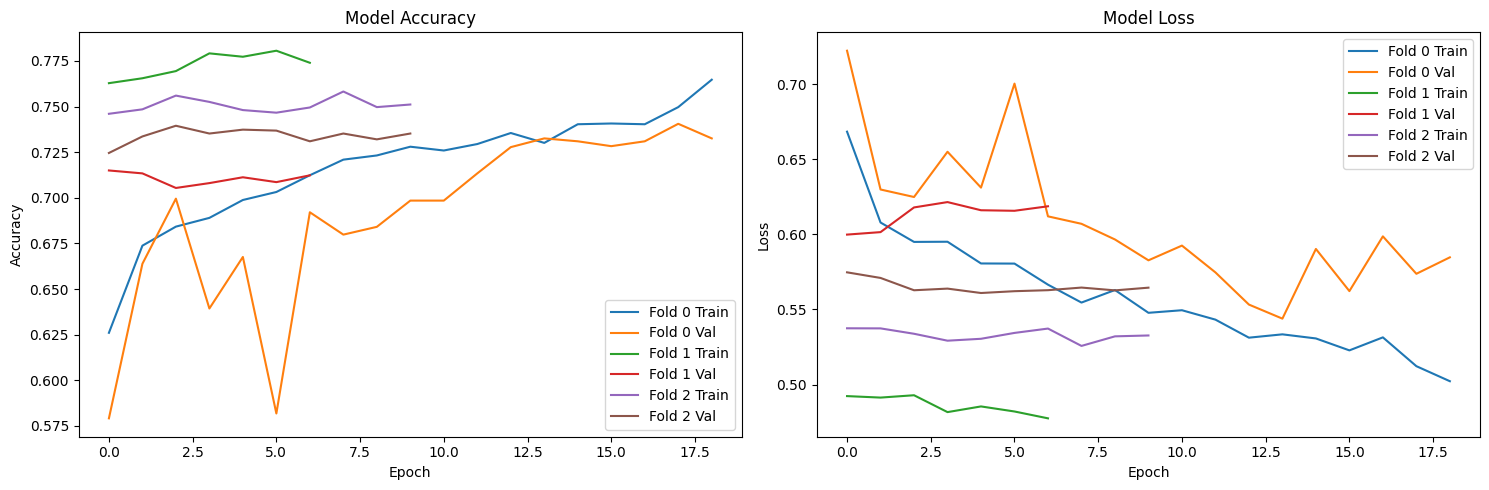

In [ ]:
# plot training history
plot_history(history)

Evaluating the model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

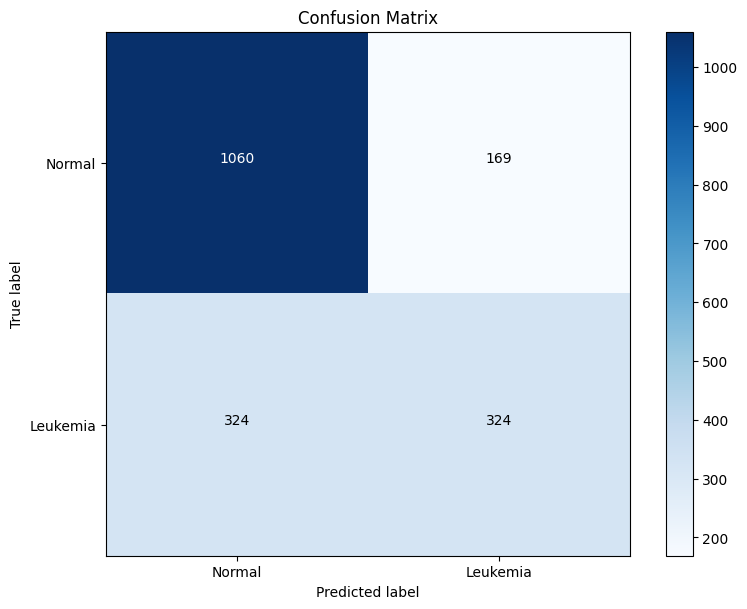

In [ ]:
# evaluate model
print("Evaluating the model...")
evaluate_model(vit_model, val_dataset)

In [ ]:
y_true = [] # list to store true class labels
y_pred = [] # list to store predicted class labels

# iterate through batches in validation dataset
for x, y in val_dataset:
    predictions = vit_model.predict(x) # get model predictions for batch
    y_true.extend(np.argmax(y.numpy(), axis=1)) # convert one-hot labels to indices and add to y_true
    y_pred.extend(np.argmax(predictions, axis=1)) # convert predicted probabilities to class indices and add to y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

AUC-ROC Score: 0.68124491


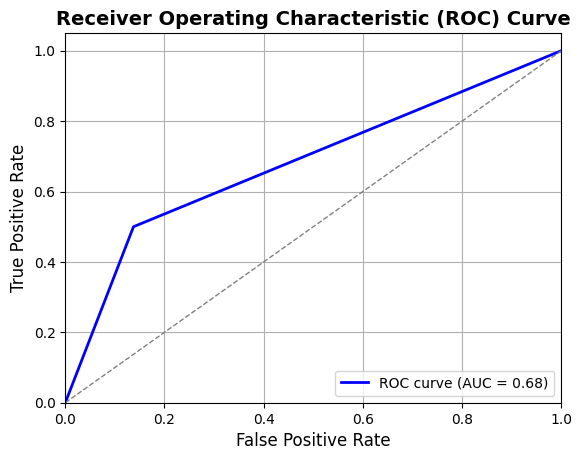

In [ ]:
# calculate AUC-ROC score
auc_roc = roc_auc_score(y_true,y_pred)
print(f"AUC-ROC Score: {auc_roc:.8f}")

# compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true,y_pred)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=12)
plt.ylabel('True Positive Rate',fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve',fontsize=14,fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# get confusion matrix
cm = confusion_matrix(y_true,y_pred)

# extract True Positives, False Negatives, False Positives, True Negatives
TN, FP, FN, TP = cm.ravel()

# calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.5000
Specificity: 0.8625


In [ ]:
# save model
vit_model.save("balanced-final_vit_leukemia_model.keras")
vit_model.save_weights("balanced-final_vit_leukemia_modev1.weights.h5")
print("Model saved successfully.")

Model saved successfully.
